In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.eigenvalues = None

    def fit(self, X):
        # Convert to PyTorch tensor if not already
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        # Center the data
        self.mean = torch.mean(X, dim=0)
        X_centered = X - self.mean

        # Compute covariance matrix
        N = X.shape[0]
        cov_matrix = torch.matmul(X_centered.T, X_centered) / (N - 1)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

        # Sort eigenvalues and corresponding eigenvectors in descending order
        idx = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Store first n_components eigenvectors
        self.components = eigenvectors[:, :self.n_components]
        self.eigenvalues = eigenvalues[:self.n_components]

        return self

    def transform(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        X_centered = X - self.mean
        return torch.matmul(X_centered, self.components)

    def inverse_transform(self, X_transformed):
        return torch.matmul(X_transformed, self.components.T) + self.mean


def load_and_preprocess_data(train_path, test_path):
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Separate labels and features
    X_train = train_data.drop('label', axis=1).values
    y_train = train_data['label'].values
    X_test = test_data.drop('label', axis=1).values
    y_test = test_data['label'].values

    # Convert to PyTorch tensors and normalize
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32) / 255.0
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32) / 255.0
    y_train_tensor = torch.tensor(y_train)
    y_test_tensor = torch.tensor(y_test)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

In [2]:
def plot_image_pair(original, reconstructed, title):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [3]:
 # Load the data
X_train, y_train, X_test, y_test = load_and_preprocess_data('mnist_train.csv', 'mnist_test.csv')

# Apply PCA with L=128
pca = PCA(n_components=128)
pca.fit(X_train)

# Transform and reconstruct training data
X_train_transformed = pca.transform(X_train)
X_train_reconstructed = pca.inverse_transform(X_train_transformed)

# Transform and reconstruct test data
X_test_transformed = pca.transform(X_test)
X_test_reconstructed = pca.inverse_transform(X_test_transformed)

# Calculate and print reconstruction error
train_mse = torch.mean((X_train - X_train_reconstructed) ** 2)
test_mse = torch.mean((X_test - X_test_reconstructed) ** 2)
print(f"Training Data Reconstruction MSE: {train_mse.item()}")
print(f"Test Data Reconstruction MSE: {test_mse.item()}")

Training Data Reconstruction MSE: 0.004272075369954109
Test Data Reconstruction MSE: 0.004205333534628153


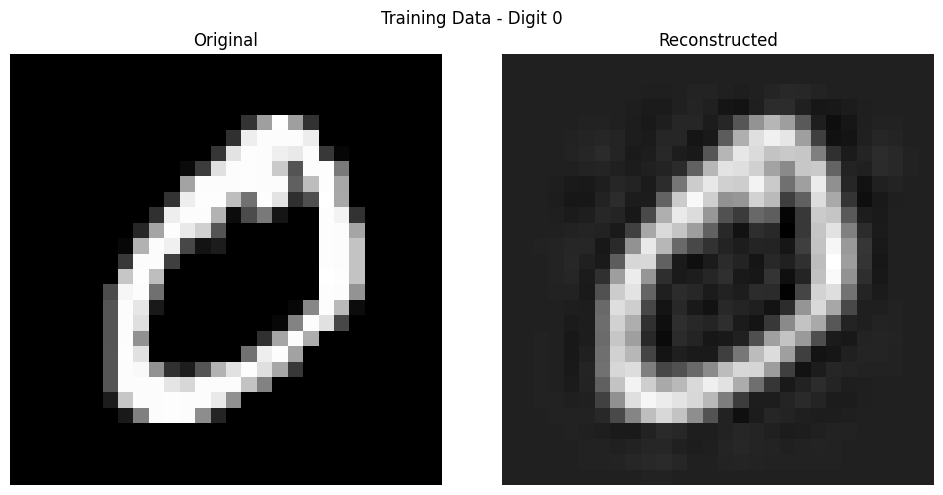

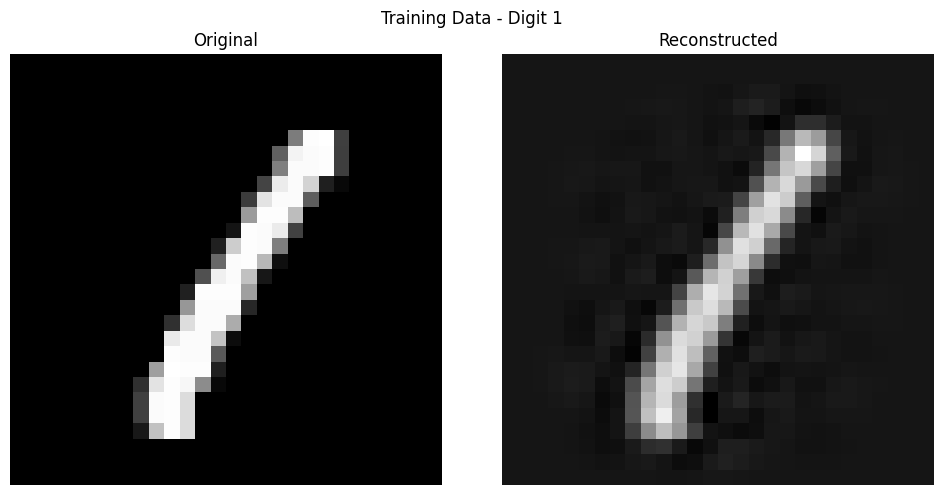

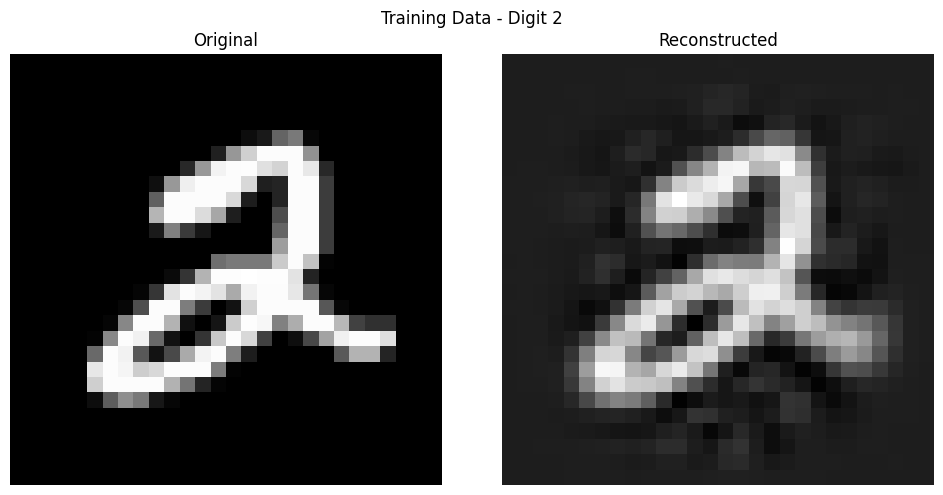

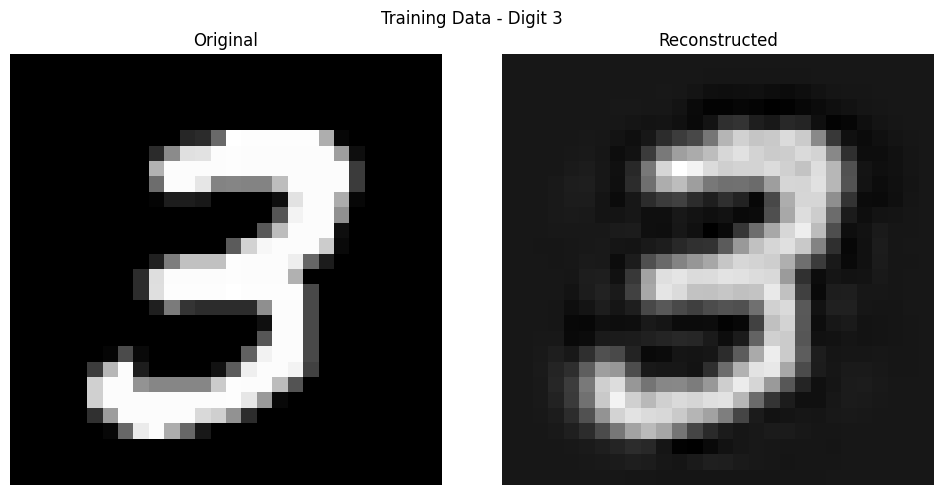

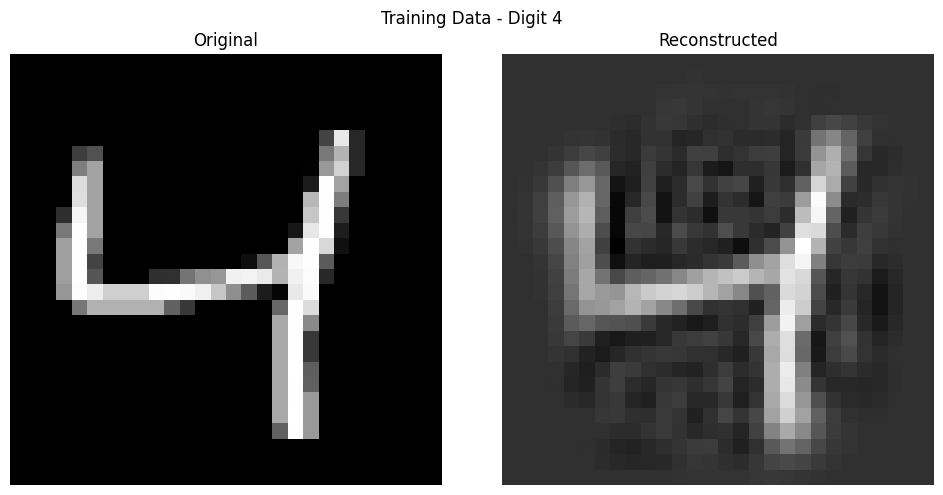

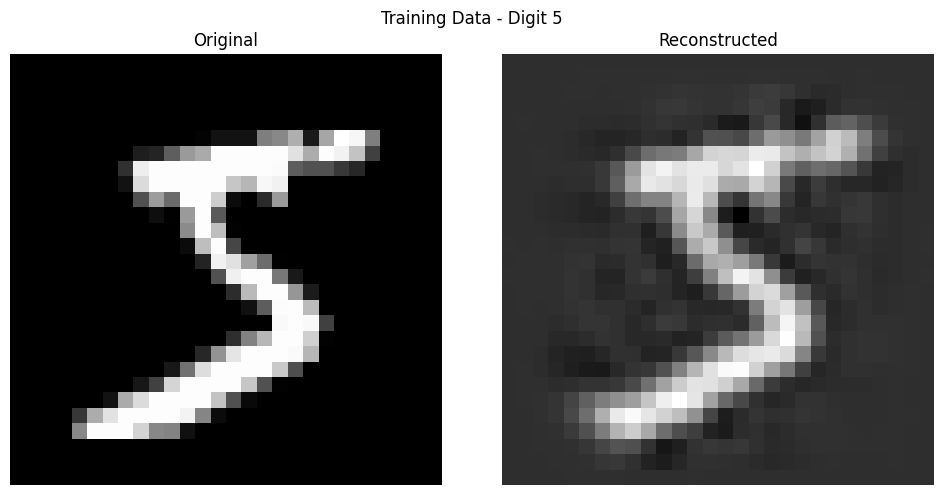

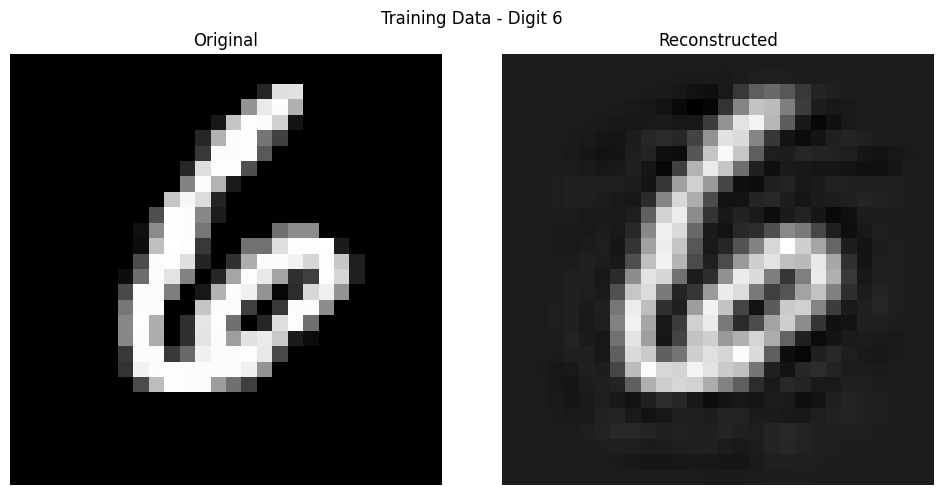

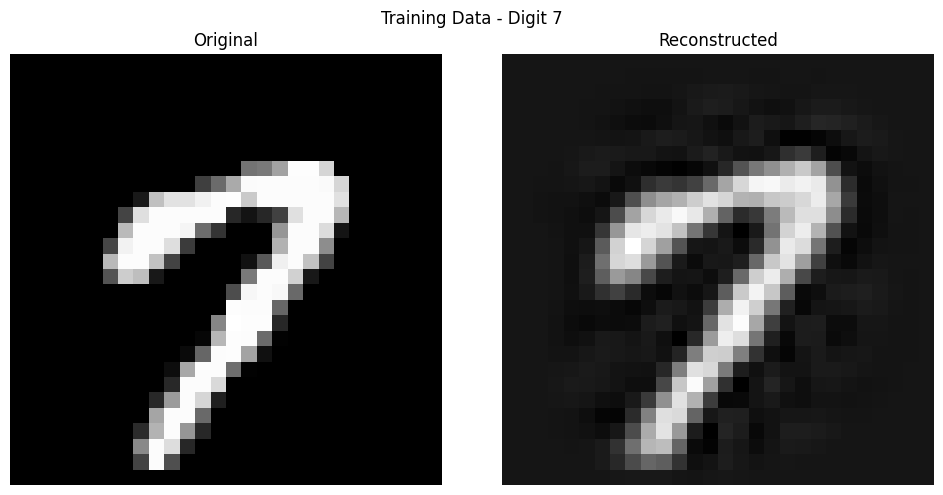

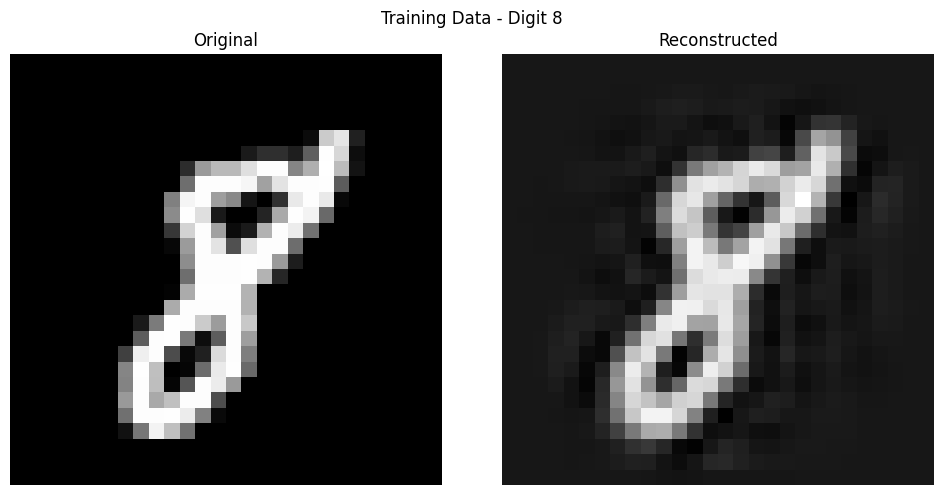

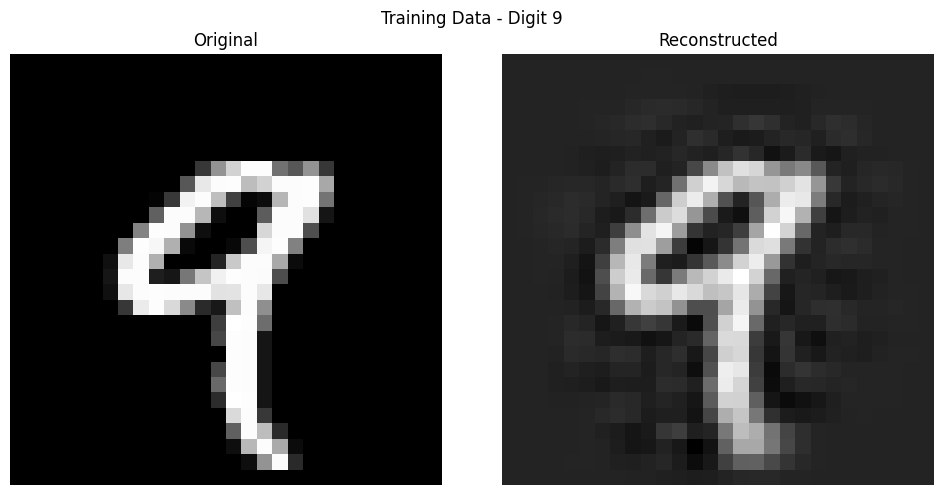

In [4]:
# Select and plot some example image pairs
# Training data
for digit in range(10):
# Find indices of this digit in training data
        digit_indices = torch.where(y_train == digit)[0]
        if len(digit_indices) > 0:
            # Select the first image of this digit
            idx = digit_indices[0]
            plot_image_pair(
                X_train[idx],
                X_train_reconstructed[idx],
                f'Training Data - Digit {digit}'
            )

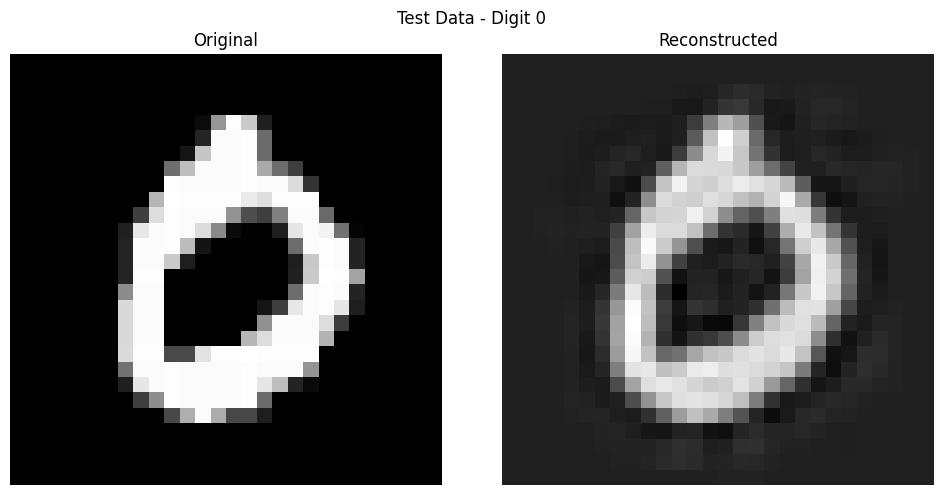

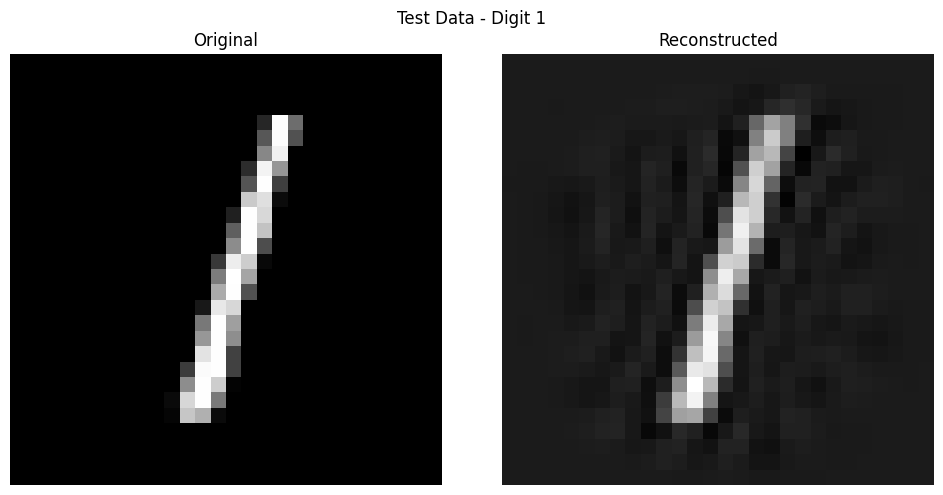

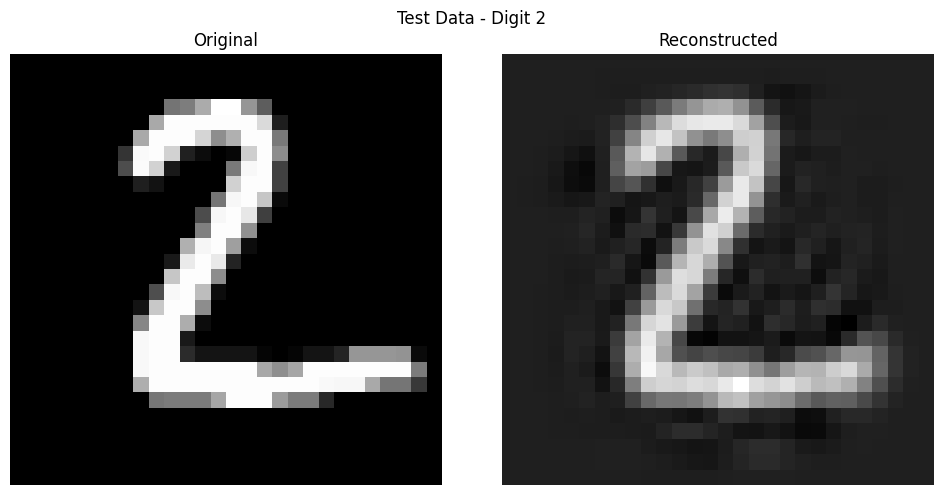

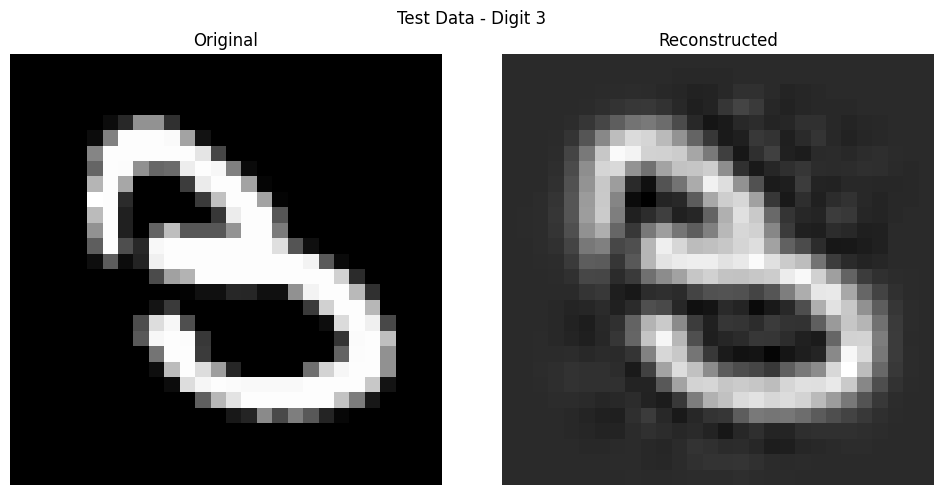

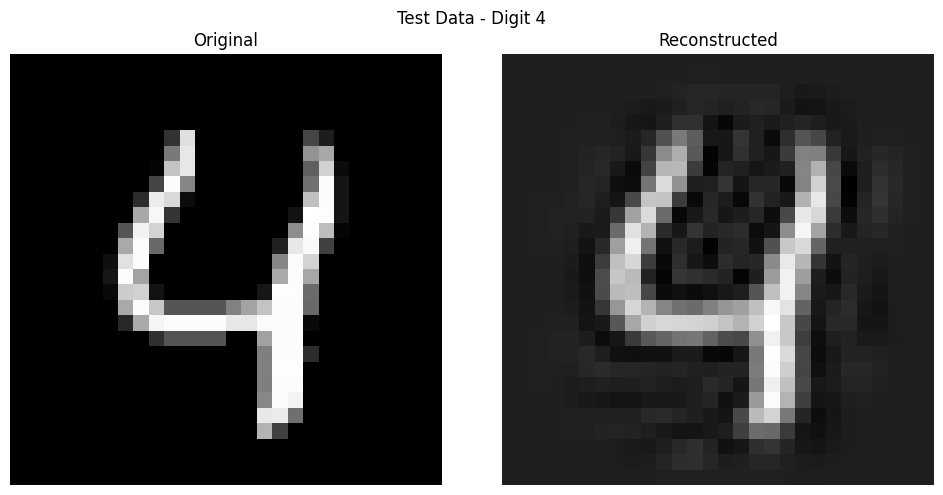

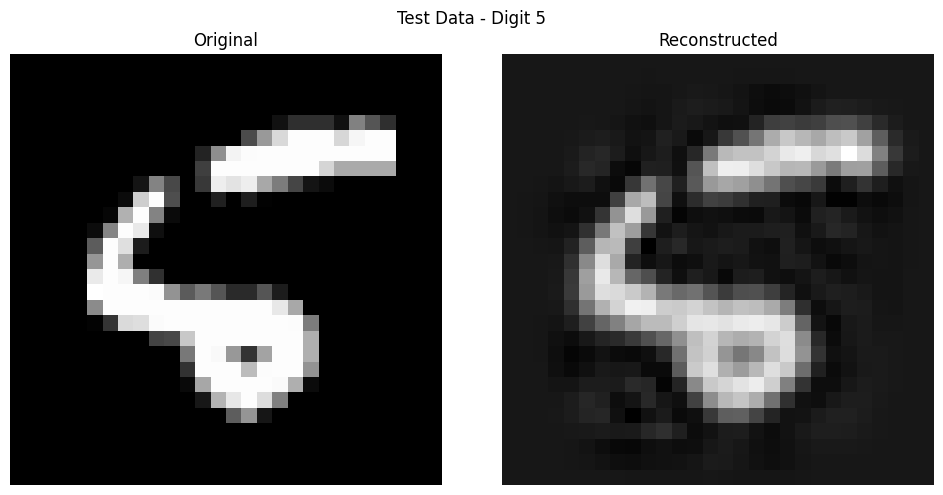

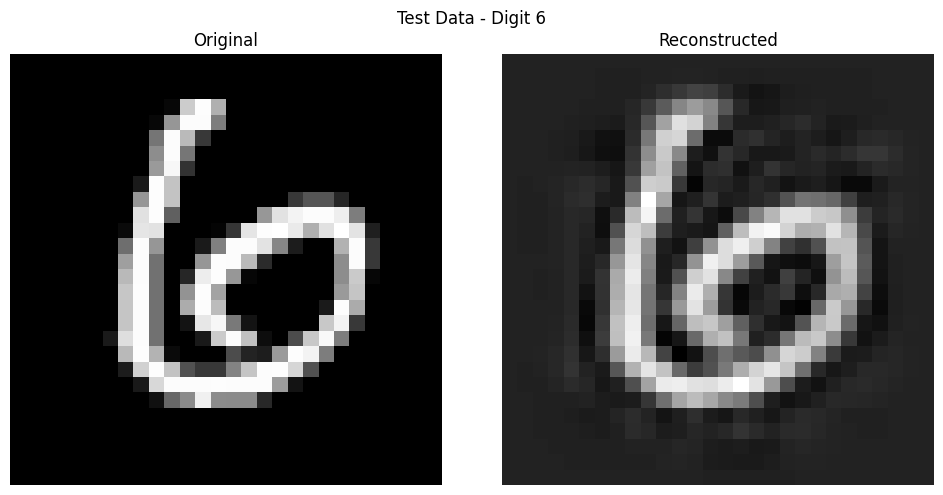

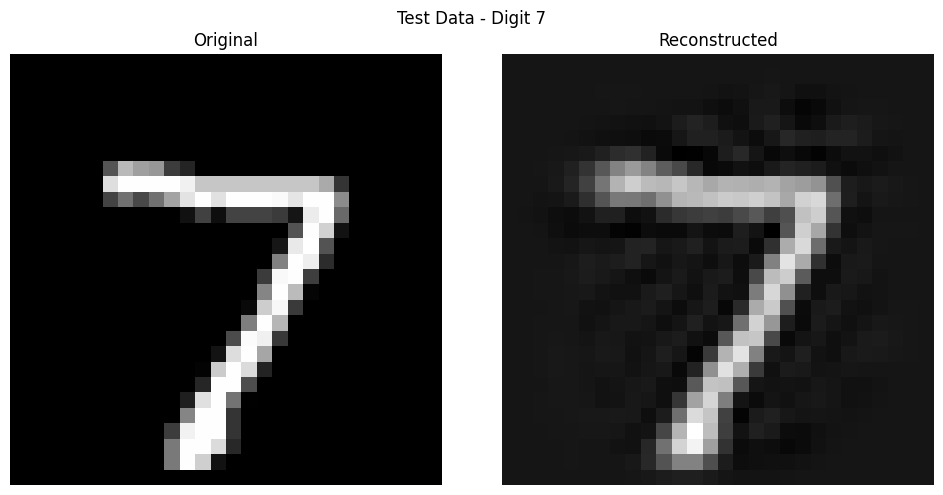

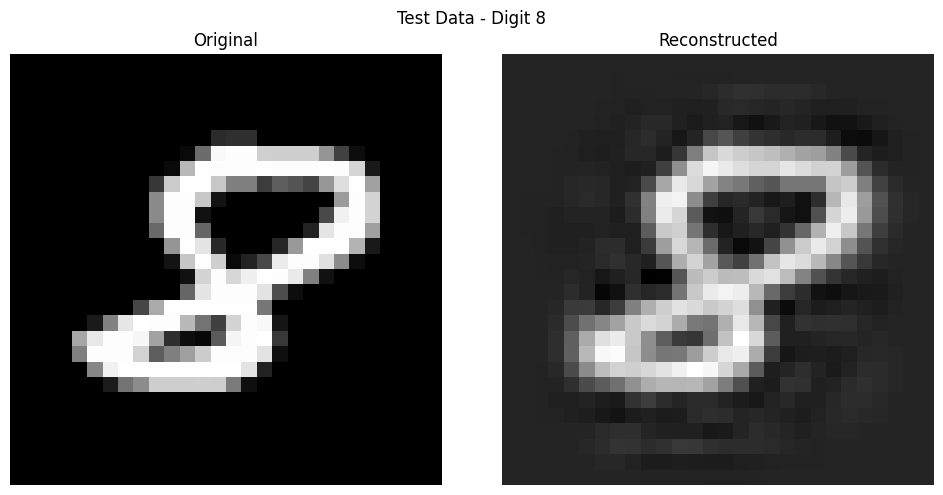

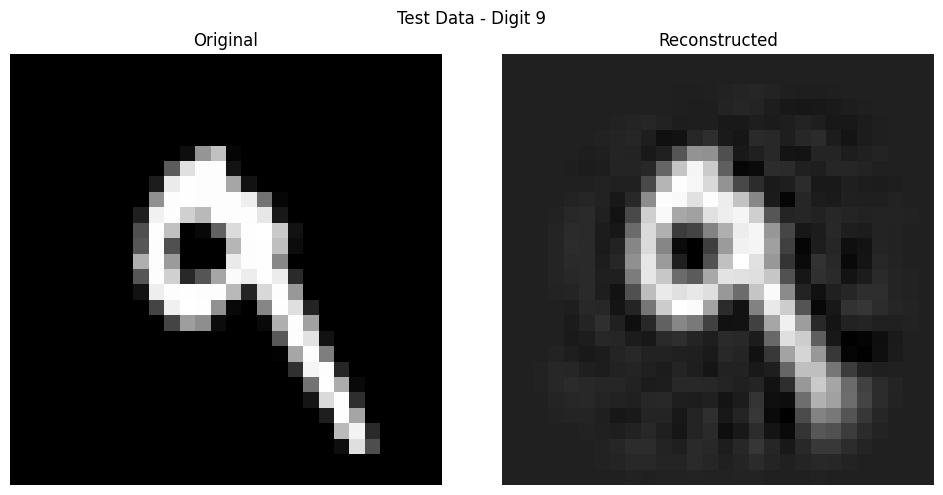

In [5]:
 # Test data
for digit in range(10):
        # Find indices of this digit in test data
        digit_indices = torch.where(y_test == digit)[0]
        if len(digit_indices) > 0:
            # Select the first image of this digit
            idx = digit_indices[0]
            plot_image_pair(
                X_test[idx],
                X_test_reconstructed[idx],
                f'Test Data - Digit {digit}'
            )